In [1]:
import json
import matplotlib.pyplot as plt

import numpy as np
import math

In [2]:
fig_size = (8, 6)
dpi = 200
timeStep = 3600 # Seconds

with open('kpis-uc1.json', 'r') as f:
    kpis_uc1 = json.load(f)
    print("KPIs for UC1:")
    [print(i) for i in kpis_uc1.keys()]

with open('kpis-uc2.json', 'r') as f:
    kpis_uc2 = json.load(f)
    print("\nKPIs for UC2:")
    [print(i) for i in kpis_uc2.keys()]


KPIs for UC1:
total_throughput_GB
daily_avg_throughput_GB
total_power_consumption_kWh
daily_avg_power_consumption_kWh
yearly_power_estimate_kWh
availability_percentage
blocked_traffic_GB
throughput_time_series_gbps
power_time_series_kWh

KPIs for UC2:
total_throughput_GB
daily_avg_throughput_GB
total_power_consumption_kWh
daily_avg_power_consumption_kWh
yearly_power_estimate_kWh
availability_percentage
blocked_traffic_GB
throughput_time_series_gbps
power_time_series_kWh


# Gráficas de tráfico

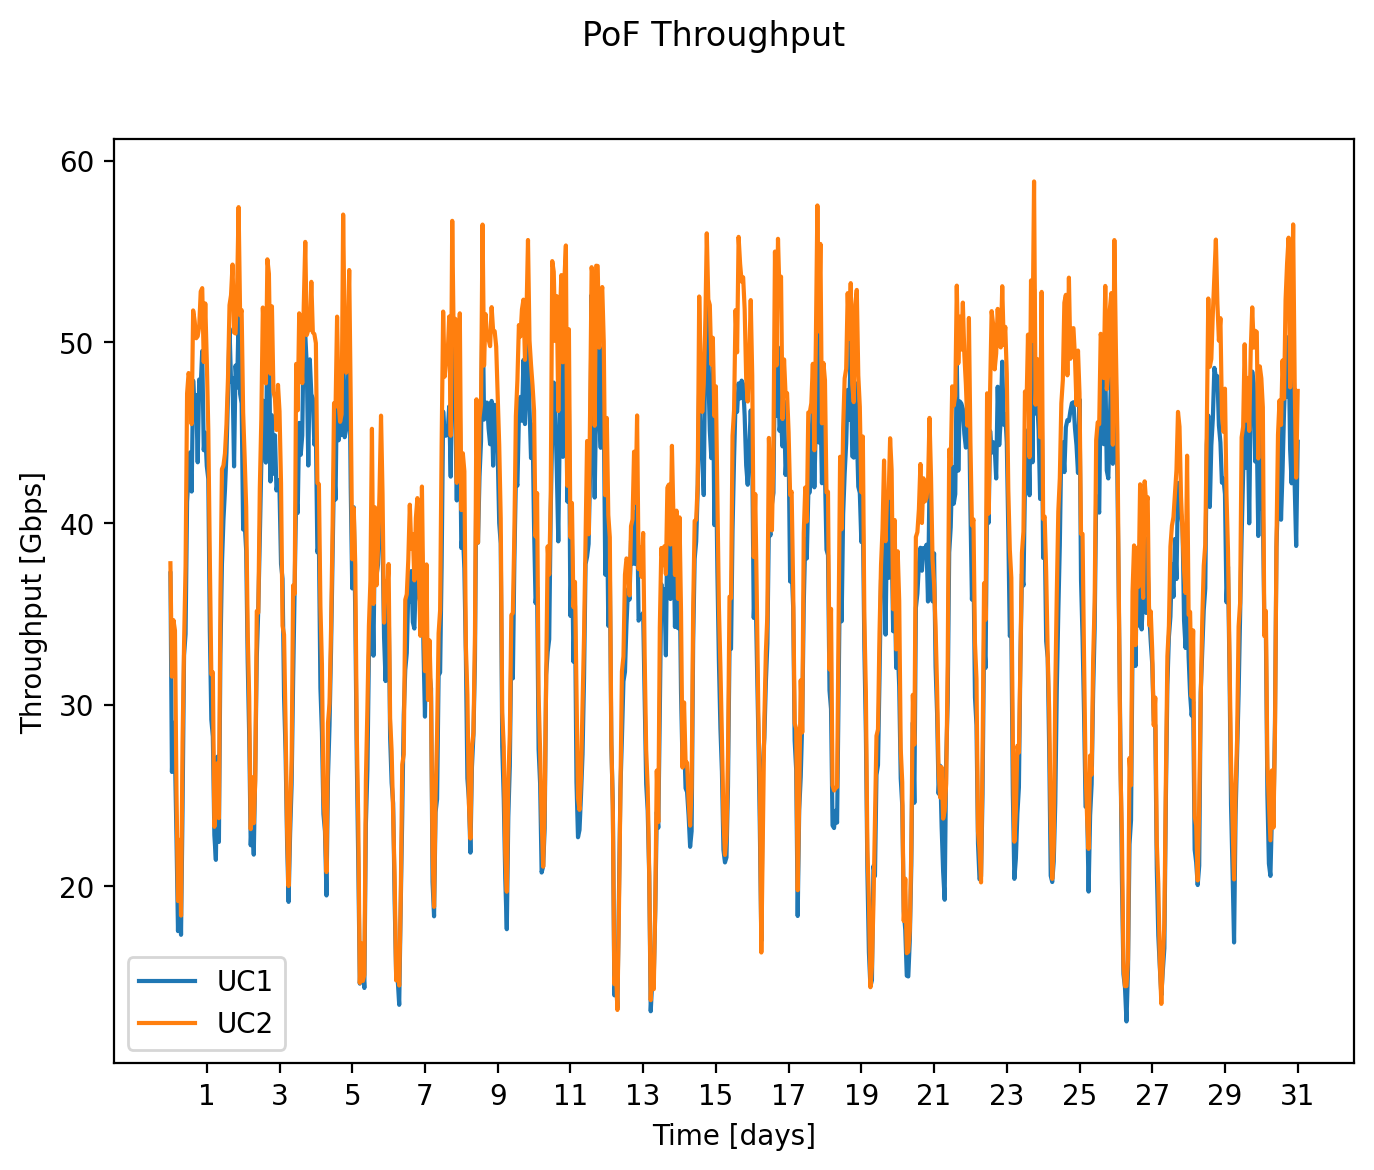

In [3]:
fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)


y_1 = kpis_uc1['throughput_time_series_gbps']
y_2 = kpis_uc2['throughput_time_series_gbps']

# Asumimos que cada muestra es 1 hora, durante 1 mes (~30 días)
num_samples = len(y_1)
hours_per_sample = 1
total_hours = num_samples * hours_per_sample
total_days = total_hours / 24

# Eje X en días
x_1 = np.arange(0, num_samples) * hours_per_sample / 24
x_2 = np.arange(0, len(y_2)) * hours_per_sample / 24

# Configurar los ticks del eje x para mostrar solo los días impares
ax.set_xlabel('Time [days]')
max_tick = math.ceil(x_1[-1])
# Días impares: 1, 3, 5, ..., hasta el máximo día
ticks = np.arange(1, max_tick + 1, 2)
ax.set_xticks(ticks)
ax.set_xticklabels([f'{int(x)}' for x in ticks])

fig.suptitle('PoF Throughput')
ax.plot(x_1[:len(y_1)], y_1, label='UC1')
ax.plot(x_2[:len(y_2)], y_2, label='UC2')
# ax.legend()
ax.set_ylabel('Throughput [Gbps]')
ax.set_xlabel('Time [days]')
ax.legend()

# Gráficas de potencia

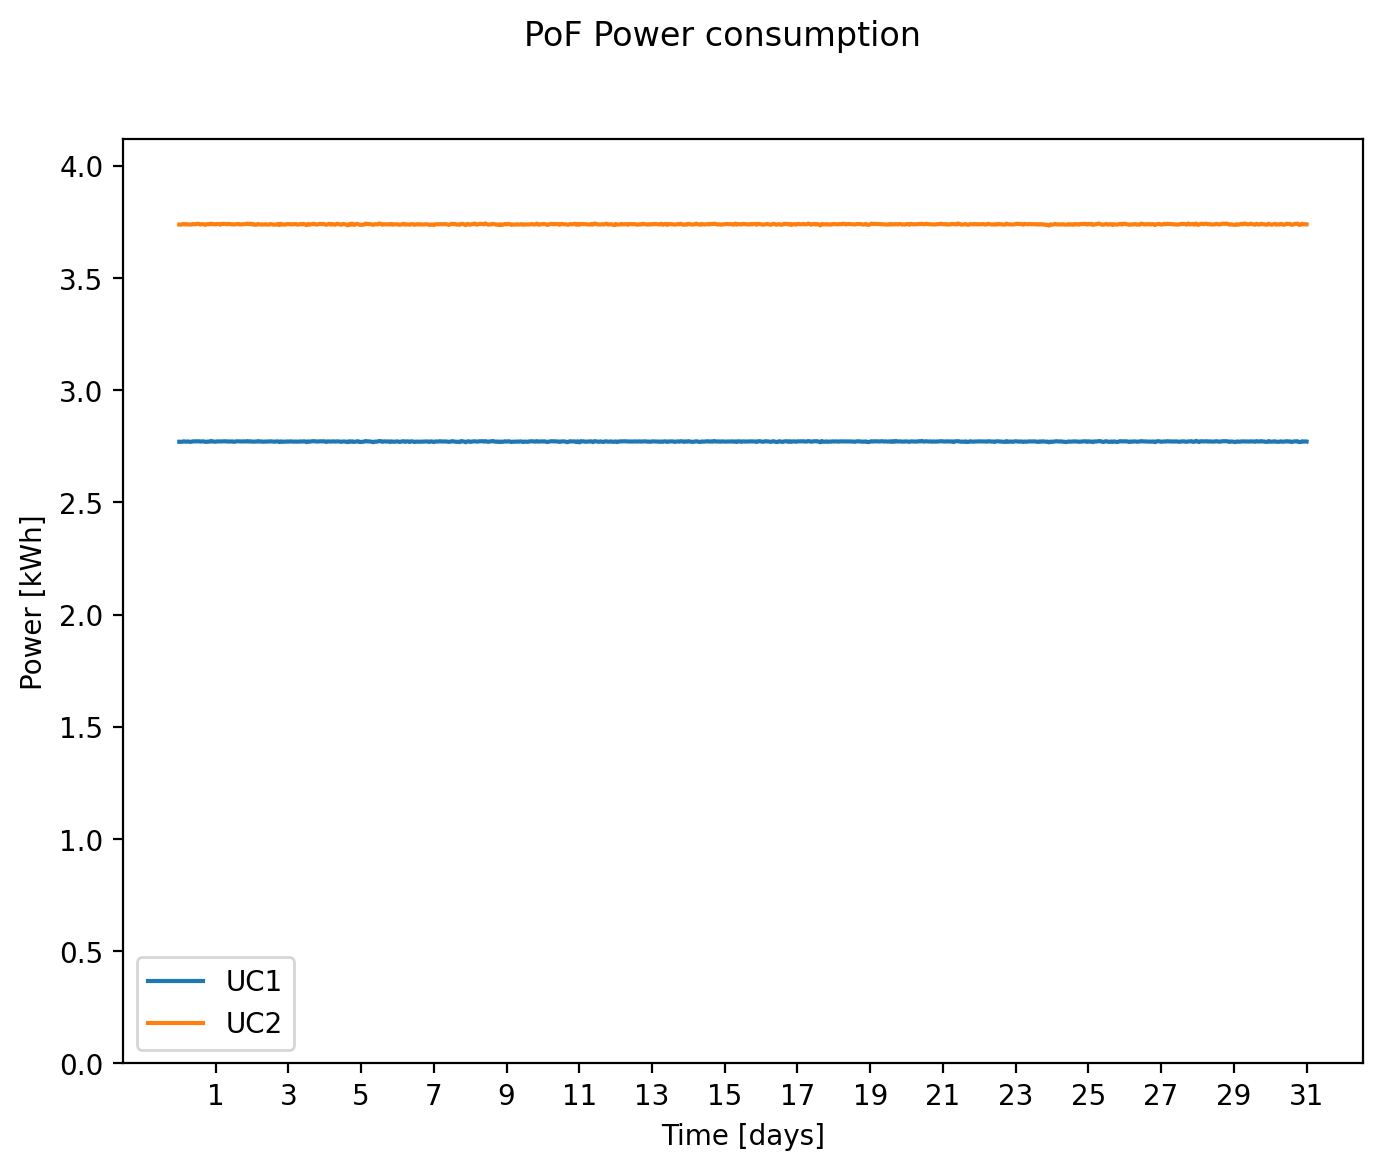

In [4]:
fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)


def get_max_power_femto(num_pof_pools):
    return num_pof_pools * 5 * 0.7

def transform_to_real_power_kwatts(num_pof_pools: int, power_series):
    ptx_on = 0.0136*30 + 27.34
    ptx_off = 27.34
    
    real_power_series = []
    max_femtos = num_pof_pools * 5
    
    for i in range(len(power_series)):
        p_i = power_series[i] * 1000 # Watts
        # Calcular el número de femtos activos en el instante i
        # Cada femto consume 0.7W, por lo que el número de femtos activos es:
        num_femtos_active = p_i / 0.7
        # Si quieres el número entero más cercano:
        num_femtos_active = int(round(num_femtos_active))
        
        power_this_series = ptx_on * num_femtos_active + ptx_off * (max_femtos - num_femtos_active)
        real_power_series.append(power_this_series/1000)
        
    return real_power_series
        
        

        


y_1 = kpis_uc1['power_time_series_kWh']
# y_1 = [i * 1e3 for i in y_1]
y_1 = transform_to_real_power_kwatts(num_pof_pools=20, power_series=y_1)
y_2 = kpis_uc2['power_time_series_kWh']
# y_2 = [i * 1e3 for i in y_2]
y_2 = transform_to_real_power_kwatts(num_pof_pools=27, power_series=y_2)
# Asumimos que cada muestra es 1 hora, durante 1 mes (~30 días)
num_samples = len(y_1)
hours_per_sample = 1
total_hours = num_samples * hours_per_sample
total_days = total_hours / 24

# Eje X en días
x_1 = np.arange(0, num_samples) * hours_per_sample / 24
x_2 = np.arange(0, len(y_2)) * hours_per_sample / 24

# Configurar los ticks del eje x para mostrar solo los días impares
ax.set_xlabel('Time [days]')
max_tick = math.ceil(x_1[-1])
# Días impares: 1, 3, 5, ..., hasta el máximo día
ticks = np.arange(1, max_tick + 1, 2)
ax.set_xticks(ticks)
ax.set_xticklabels([f'{int(x)}' for x in ticks])

fig.suptitle('PoF Power consumption')
ax.plot(x_1[:len(y_1)], y_1, label='UC1')
ax.plot(x_2[:len(y_2)], y_2, label='UC2')
# ax.set_ylim(0, max(max(y_1), max(y_2))*1.1)
ax.set_ylabel('Power [kWh]')
ax.set_xlabel('Time [days]')
ax.legend()

## UC1 100 femtos, 20 PoF Pools
$ t = 3600\,\text{s} $ (1 paso de simulación)

- Consumo de femtos: $62.2\,\text{W}$
- Consumo de cada femto: $0.7\,\text{W}$
- Número de femtos activas: $89\,\text{femtos}$ (utilizar 89 HPLDs)
- Número de PoF Pools: $20$
- Número de láseres: $20 \times 5 = 100\,\text{HPLDs}$ (equivalente a alimentar 100 femtoceldas simultáneas)

$
p_\text{on} = 89 \times (0.0136 \times 30 + 27.34) = 89 \times 27.748 = 2469.572\,\text{W} = 2.47\,\text{kW}
$

$
p_\text{off} = (100 - 89) \times 27.34 = 11 \times 27.34 = 300.74\,\text{W} = 0.3\,\text{kW}
$

$
p_\text{total} = p_\text{on} + p_\text{off} = 2.47 + 0.3 = 2.77\,\text{kW}
$

Teniendo en cuenta que el delta de tiempo $\Delta t$ (timeStep) es 1 hora:
$
\text{Energía} = p_\text{total} \times \Delta t = 2.77\,\text{kWh}
$

¿Se asemeja con el cálculo obtenido en los cálculos de la celda anterior? $2.7703\,\text{kWh}$ → sí, es correcto.

## UC2 134 femtos, 27 PoF Pools
$ t = 3600\,\text{s} $ (1 paso de simulación)

- Consumo de femtos: $81.45\,\text{W}$
- Consumo de cada femto: $0.7\,\text{W}$
- Número de femtos activas: $117\,\text{femtos}$ (utilizar 117 HPLDs)
- Número de PoF Pools: $27$
- Número de láseres: $27 \times 5 = 135\,\text{HPLDs}$ (equivalente a alimentar 135 femtoceldas simultáneas)

$
p_\text{on} = 117 \times (0.0136 \times 30 + 27.34) = 117 \times 27.748 = 3246.52\,\text{W} = 3.25\,\text{kW}
$

$
p_\text{off} = (135 - 117) \times 27.34 = 18 \times 27.34 = 492.12\,\text{W} = 0.49\,\text{kW}
$

$
p_\text{total} = p_\text{on} + p_\text{off} = 3.25 + 0.49 = 3.74\,\text{kW}
$

Teniendo en cuenta que el delta de tiempo $\Delta t$ (timeStep) es 1 hora:
$
\text{Energía} = p_\text{total} \times \Delta t = 3.74\,\text{kWh}
$

¿Se asemeja con el cálculo obtenido en los cálculos de la celda anterior? $3.738\,\text{kWh}$ → sí, es correcto.

# Cálculo de estadísticos

In [11]:
consumo_total_uc1 = sum(y_1)
consumo_total_uc2 = sum(y_2)


consumo_diario_uc1 = consumo_total_uc1 / 31
consumo_diario_uc2 = consumo_total_uc2 / 31

estimacion_1_año_uc1 = consumo_diario_uc1 * 365
estimacion_1_año_uc2 = consumo_diario_uc2 * 365



print("Consumos UC1:")
print(f"Consumo total 1 mes 31 días UC1: {consumo_total_uc1:.2f} kWh")
print(f"Consumo diario UC1: {consumo_diario_uc1:.2f} kWh")
print(f"Estimación 1 año UC1: {estimacion_1_año_uc1:.2f} kWh")



print("\nConsumos UC2:")
print(f"Consumo total 1 mes 31 días UC2: {consumo_total_uc2:.2f} kWh")
print(f"Consumo diario UC2: {consumo_diario_uc2:.2f} kWh")
print(f"Estimación 1 año UC2: {estimacion_1_año_uc2:.2f} kWh")

Consumos UC1:
Consumo total 1 mes 31 días UC1: 2064.63 kWh
Consumo diario UC1: 66.60 kWh
Estimación 1 año UC1: 24309.38 kWh

Consumos UC2:
Consumo total 1 mes 31 días UC2: 2785.86 kWh
Consumo diario UC2: 89.87 kWh
Estimación 1 año UC2: 32801.21 kWh


## Corregir los datos en un fichero primo

In [14]:
kpis_uc1_copy = kpis_uc1.copy()
kpis_uc2_copy = kpis_uc2.copy()

kpis_uc1_copy['power_time_series_kWh'] = y_1
kpis_uc2_copy['power_time_series_kWh'] = y_2

kpis_uc1_copy['daily_avg_power_consumption_kWh'] = consumo_diario_uc1
kpis_uc2_copy['daily_avg_power_consumption_kWh'] = consumo_diario_uc2

kpis_uc1_copy['yearly_power_estimate_kWh'] = estimacion_1_año_uc1
kpis_uc2_copy['yearly_power_estimate_kWh'] = estimacion_1_año_uc2

with open('kpis-uc1-corregido.json', 'w') as f:
    json.dump(kpis_uc1_copy, f, indent=4)

with open('kpis-uc2-corregido.json', 'w') as f:
    json.dump(kpis_uc2_copy, f, indent=4)

